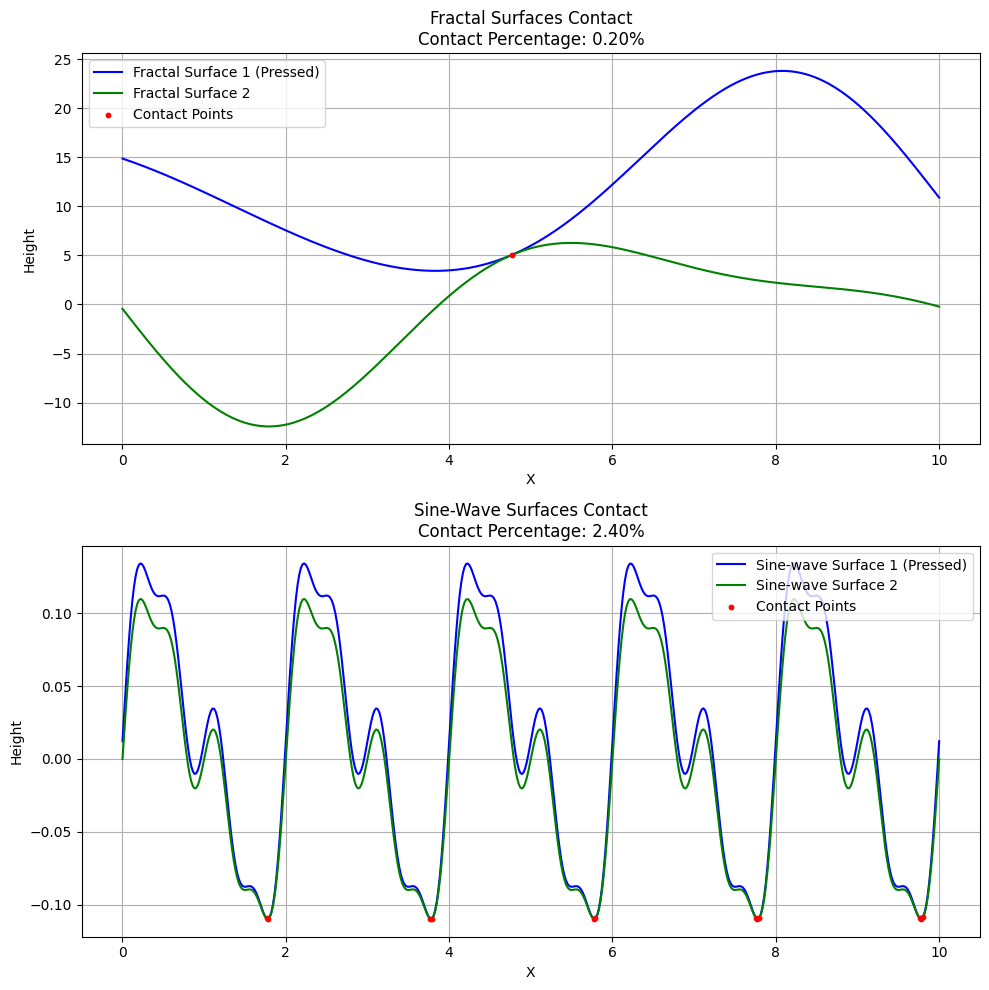

=== Results ===
Fractal Surfaces Contact Percentage: 0.20%
Sine-Wave Surfaces Contact Percentage: 2.40%


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Adjusted parameters for more stable fractal generation
L = 10.0
D_f = 1.5      # A dimension closer to mid-range
gamma = 1.2    # Lower gamma to reduce amplitude escalation
M = 3          # Fewer angular divisions
N_max = 5       # Fewer frequencies for stability

np.random.seed(42)
phi = 2 * np.pi * np.random.rand(M, N_max)

def fractal_noise_ausloos_berman(x, L=L, D_f=D_f, gamma=gamma, M=M, N_max=N_max, phi=phi):
    # According to the given formula:
    # y(x) = L^(4 - 2*D_f)*ln(γ)*Σ_m Σ_n [γ^( (n-1)*2(D_f-2) ) * cos(2πγ^(n-1)x/L - cos(πm/M) + φ_mn)]
    prefactor = (L**(4 - 2*D_f)) * math.log(gamma)
    val = 0.0
    for m in range(1, M+1):
        for n in range(1, N_max+1):
            exp_factor = (n-1)*2*(D_f-2)
            freq = gamma**(n-1)
            arg = (2*math.pi*freq*x/L) - math.cos(math.pi*m/M) + phi[m-1, n-1]
            val += (gamma**exp_factor)*math.cos(arg)
    return prefactor * val

def sine_wave_surface(x, frequencies=[1,2,4], amplitudes=[0.1,0.05,0.025]):
    val = 0.0
    for f, a in zip(frequencies, amplitudes):
        val += a * np.sin(2 * np.pi * f * x)
    return val

def find_max_contact_offset(f1, f2, tolerance=1e-4):
    def infiltration_occurs(offset):
        return np.any((f1 + offset) < f2)
    
    # Ensure we start at a high offset with no infiltration
    test_offset = 10.0
    while infiltration_occurs(test_offset):
        test_offset *= 2
        if test_offset > 1e6:
            raise ValueError("Surfaces too extreme; cannot avoid infiltration even at very high offset.")
    
    # Now we know at test_offset there's no infiltration, use it as 'high' bound in binary search
    high = test_offset
    low = -5.0
    for _ in range(100):
        mid = (low + high) / 2
        if np.all((f1 + mid) > f2):
            # Can still reduce offset
            high = mid
        else:
            # infiltration or contact at mid, need to lift
            low = mid
    offset = high

    # Press further
    press_step = 1e-3
    last_safe_offset = offset
    while True:
        test_offset = offset - press_step
        if infiltration_occurs(test_offset):
            # too far
            press_step /= 2
            if press_step < 1e-12:
                break
        else:
            offset = test_offset
            last_safe_offset = offset
    
    f1_contact = f1 + last_safe_offset
    diff = f1_contact - f2
    contact_mask = (diff >= 0) & (diff <= tolerance)
    contact_percentage = (np.sum(contact_mask) / len(f1)) * 100
    return last_safe_offset, contact_percentage, contact_mask

# Simulation parameters
size = 500
x_vals = np.linspace(0, 10, size)

# Fractal Surfaces
f1_fractal = np.array([fractal_noise_ausloos_berman(x) for x in x_vals])
f2_fractal = np.array([fractal_noise_ausloos_berman(x+10) for x in x_vals])

offset_fractal, contact_perc_fractal, contact_mask_fractal = find_max_contact_offset(f1_fractal, f2_fractal, tolerance=1e-4)
f1_fractal_contact = f1_fractal + offset_fractal

# Sine-Wave Surfaces
f1_sine = np.array([sine_wave_surface(x, frequencies=[0.5,1,2], amplitudes=[0.1,0.05,0.025]) for x in x_vals])
f2_sine = np.array([sine_wave_surface(x, frequencies=[0.5,1,2], amplitudes=[0.1,0.05,0.025]) for x in x_vals]) * 0.9

offset_sine, contact_perc_sine, contact_mask_sine = find_max_contact_offset(f1_sine, f2_sine, tolerance=1e-4)
f1_sine_contact = f1_sine + offset_sine

fig, axes = plt.subplots(2,1,figsize=(10,10))

# Fractal Surfaces
axes[0].plot(x_vals, f1_fractal_contact, label="Fractal Surface 1 (Pressed)", color='blue')
axes[0].plot(x_vals, f2_fractal, label="Fractal Surface 2", color='green')
axes[0].scatter(x_vals[contact_mask_fractal], f1_fractal_contact[contact_mask_fractal],
                color='red', s=10, label='Contact Points', zorder=5)
axes[0].set_title(f"Fractal Surfaces Contact\nContact Percentage: {contact_perc_fractal:.2f}%")
axes[0].set_xlabel("X")
axes[0].set_ylabel("Height")
axes[0].grid(True)
axes[0].legend()

# Sine-Wave Surfaces
axes[1].plot(x_vals, f1_sine_contact, label="Sine-wave Surface 1 (Pressed)", color='blue')
axes[1].plot(x_vals, f2_sine, label="Sine-wave Surface 2", color='green')
axes[1].scatter(x_vals[contact_mask_sine], f1_sine_contact[contact_mask_sine],
                color='red', s=10, label='Contact Points', zorder=5)
axes[1].set_title(f"Sine-Wave Surfaces Contact\nContact Percentage: {contact_perc_sine:.2f}%")
axes[1].set_xlabel("X")
axes[1].set_ylabel("Height")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

print("=== Results ===")
print(f"Fractal Surfaces Contact Percentage: {contact_perc_fractal:.2f}%")
print(f"Sine-Wave Surfaces Contact Percentage: {contact_perc_sine:.2f}%")
